In [ ]:
# default_exp model_fitting

# CMR Parameter Configurations Across Murdock (1962) Conditions
Classic behavior data reported by Murdock (1962) reports performance under the immediate free recall paradigm as list length is manipulated between trials. Results identified a consistent shape across list lengths of the primacy portion of the serial position curve even as the overall probability of recall for items presented early in a list dropped with increasing list lengths. He also found that increasing list lengths reduced recall probability of mid-list items and had no effect on the recency slope corresponding to terminal items. A key result of Polyn & Kahana (2009) was that despite observed differences in serial position curves, a single set of parameters of the Context Maintenance and Retrieval (CMR) model could account for performance across all conditions. CMR could account for the behavioral effect of list length on immediate free recall in terms of the dynamics of the recall competition: as the umber of items competing for recall increases, the support for recall for any one item falls. By strongly supporting recall of terminal items though, the end of list context cue specified by CMR insulates those items from this effect. In our explorations of an instance-based variant of CMR, we reproduced this finding using log-likelihood based fitting instead of curve-based fitting, as well as a more novel different variant of the CMR model.

With this background, we set out to validate a method for characterizing the capacity of a cognitive model like CMR to account for behavior across distinct research conditions using the same parameter configuration. We will fit the model to different conditions of the Murdock (1962) dataset, with unique parameter configurations fitted for each subject. Then I'll define a function that plots from these fits and selected parameters the variation between parameter values across conditions. I'll also specify some statistical tests for comparing distributions of fitted parameter values between condition.

If the method is any good and the classical interpretation of the Murdock (1962) dataset and CMR's account of it is correct, then no significant difference should be observed between parameter distributions. Right?

## Initial Fitting
For each condition and subject, find the best fit parameters for the CMR model.

In [ ]:
from compmemlearn.model_fitting import cmr_murd_objective_function
from compmemlearn.models import Classic_CMR
from compmemlearn.datasets import prepare_murdock1962_data

murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 2)
murd_events0.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


In [ ]:
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]



In [ ]:

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

subject_trial_count = 80 # Each subject gets 80 trials/lists a piece per condition
individual_cmr_results = [[], [], []]
condition_list_lengths = [murd_length0, murd_length1, murd_length2]

for condition_index, trials in enumerate([murd_trials0, murd_trials1, murd_trials2]):
    for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
        print(condition_index, subject, start_index)

        # cost function to be minimized
        # ours scales inversely with the probability that the data could have been 
        # generated using the specified parameters and our model
        cost_function = cmr_murd_objective_function(
            List([trials[start_index:start_index+subject_trial_count]]), 
            {'item_counts': List([condition_list_lengths[condition_index]]), 'sampling_rule': 0}, free_parameters)

        individual_cmr_results[condition_index].append(differential_evolution(cost_function, bounds, disp=False))
        print(individual_cmr_results[condition_index][-1].fun)

## DataFrame Population
Next we'll build a dataframe collecting each result, subject, and condition, and the values of each corresponding fitted parameter.

In [ ]:
import pandas as pd

for_df = []
for condition_index, condition in enumerate(individual_cmr_results):

    if condition_index == 0:
        list_length = murd_length0
    elif condition_index == 1:
        list_length = murd_length1
    elif condition_index == 2:
        list_length = murd_length2

    for subject_index, subject in enumerate(condition):
        for_df.append([list_length, subject_index, subject.fun] + subject.x.tolist())

param_df = pd.DataFrame(for_df, columns = ['list_length', 'subject', 'likelihood'] + free_parameters)

param_df

,list_length,subject,likelihood,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity
0,20,0,1434.084086,0.866003,2.888439e-03,0.600744,0.002793,1.000000e+00,0.091510,7.431908e+01,63.515428,0.011631,0.392205,0.788525
1,20,1,1399.205726,0.754400,1.463047e-01,0.688468,0.129871,1.000000e+00,0.133453,7.381838e+00,52.533223,0.016196,0.406872,2.357806
2,20,2,1148.320152,0.439511,2.220446e-16,0.805277,0.256838,2.220446e-16,0.228327,1.415985e+00,87.227323,0.014905,0.513976,7.454351
3,20,3,1410.965130,0.446204,2.475741e-01,0.991518,0.008972,1.000000e+00,0.107470,3.295302e+00,83.896317,0.010433,0.502168,1.684911
4,20,4,1236.766567,0.795973,2.220446e-16,0.995835,0.000386,2.220446e-16,0.040028,1.000000e+02,59.635519,0.016243,0.406856,0.669311
5,20,5,1514.374439,0.472253,2.220446e-16,0.862693,0.288500,1.000000e+00,0.162627,3.977744e+00,46.985694,0.011517,0.400903,6.066971
6,20,6,1126.104972,0.593958,4.485089e-01,0.484964,0.367578,4.664035e-01,0.170832,1.216803e+00,49.650236,0.035659,0.384782,7.223618
7,20,7,1112.325264,0.537077,2.220446e-16,0.903662,0.325327,1.000000e+00,0.159113,4.981740e+00,84.025807,0.015801,0.507002,6.162568
8,20,8,1790.020472,0.512987,2.220446e-16,0.999998,0.026194,1.000000e+00,0.153020,5.720941e+00,11.295690,0.009247,0.329522,1.894457
9,20,9,1608.503873,0.802248,2.220446e-16,0.997550,0.000178,2.220446e-16,0.031248,1.000000e+02,89.188292,0.013174,0.327498,0.534869


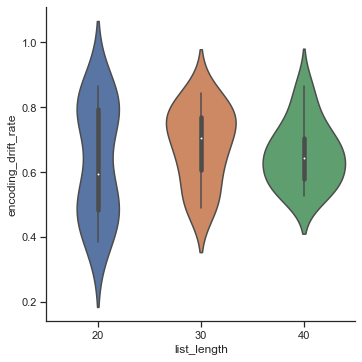

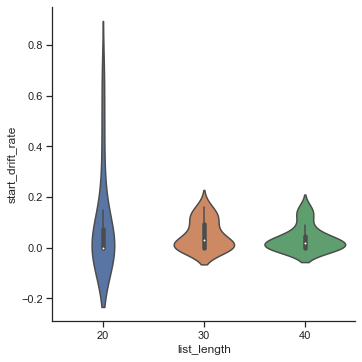

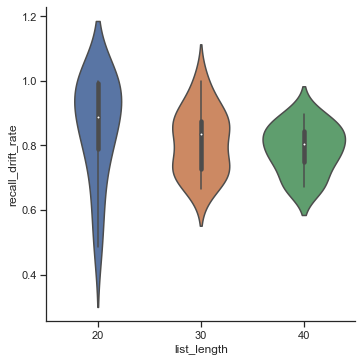

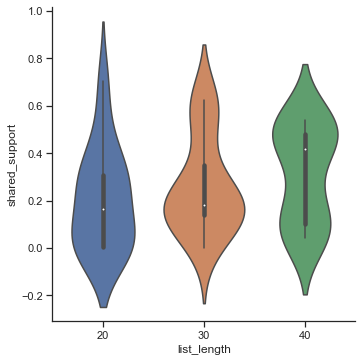

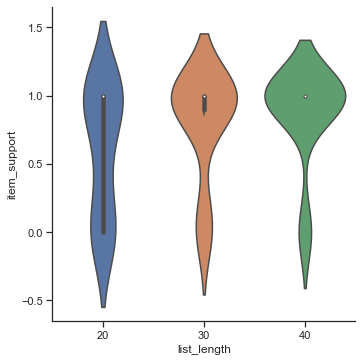

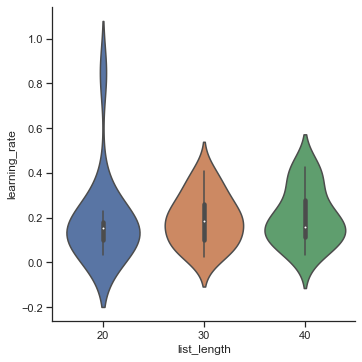

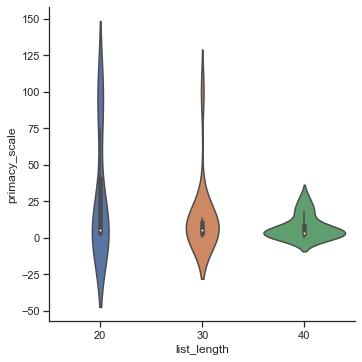

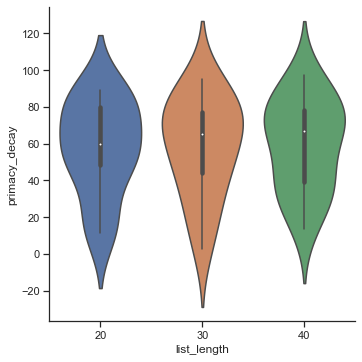

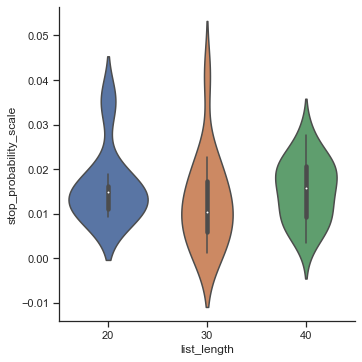

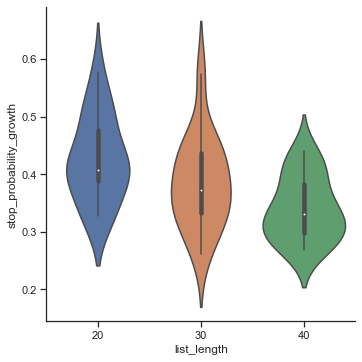

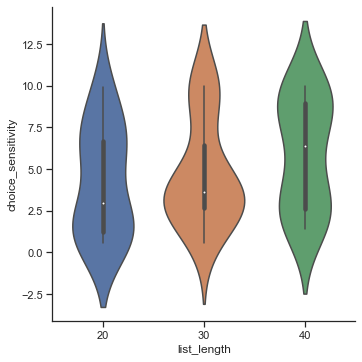

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

for parameter in free_parameters:
    g = sns.catplot(x="list_length", y=parameter, data=param_df, kind='violin')
    plt.show()

## Overall Fits Between Condition

In [ ]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

overall_cmr_results = []
subject_trial_count = 80 # Each subject gets 80 trials/lists a piece per condition
condition_list_lengths = [murd_length0, murd_length1, murd_length2]


for condition_index, trials in enumerate([murd_trials0, murd_trials1, murd_trials2]):
    print(condition_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = cmr_murd_objective_function(
        List([trials]), 
        {'item_counts': List([condition_list_lengths[condition_index]]), 'sampling_rule': 0}, free_parameters)

    overall_cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(overall_cmr_results[-1].fun)

0
21097.841186550046
1
29162.02331823793
2
29732.758098002178


In [ ]:
import pandas as pd

for_df = []
for condition_index, condition in enumerate(overall_cmr_results):

    if condition_index == 0:
        list_length = murd_length0
    elif condition_index == 1:
        list_length = murd_length1
    elif condition_index == 2:
        list_length = murd_length2

    for_df.append([list_length, condition.fun] + condition.x.tolist())

overall_param_df = pd.DataFrame(for_df, columns = ['list_length', 'likelihood'] + free_parameters)

overall_param_df

,list_length,likelihood,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity
0,20,21097.841187,0.605171,0.055894,0.848116,0.115702,0.982835,0.116393,9.250960,86.142388,0.028621,0.292290,2.701467
1,30,29162.023318,0.653377,0.106814,0.825076,0.193782,1.000000,0.162699,5.128696,55.232288,0.017247,0.277457,3.561941
2,40,29732.758098,0.633254,0.068424,0.809556,0.221524,1.000000,0.160557,4.438920,78.230170,0.016492,0.306563,4.209234


In [ ]:
from compmemlearn.datasets import simulate_data
from psifr import fr

model0 = Classic_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[0].x[i] for i in range(len(overall_cmr_results[0].x))}})

model1 = Classic_CMR(
    **{**{'item_count': murd_length1, 'presentation_count': murd_length1, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[1].x[i] for i in range(len(overall_cmr_results[1].x))}})

model2 = Classic_CMR(
    **{**{'item_count': murd_length2, 'presentation_count': murd_length2, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[2].x[i] for i in range(len(overall_cmr_results[2].x))}})

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)

dfs = [sim_df0, sim_df1, sim_df2]
labels = ['20', '30', '40']

spc = pd.concat([fr.spc(df) for df in dfs], keys=labels, names=['list_length']).reset_index()
lag_crp = pd.concat([fr.lag_crp(df) for df in dfs], keys=labels, names=['list_length']).reset_index()
pfr = pd.concat([fr.pnr(df) for df in dfs], keys=labels, names=['list_length']).reset_index()
pfr = pfr.query('output <= 1')

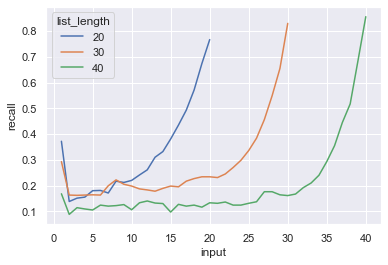

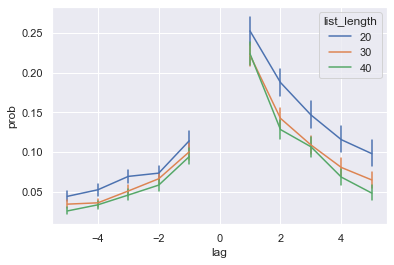

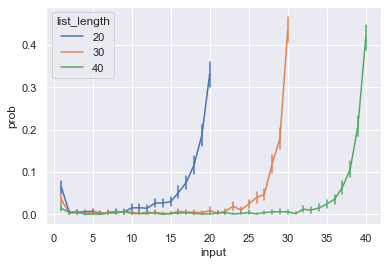

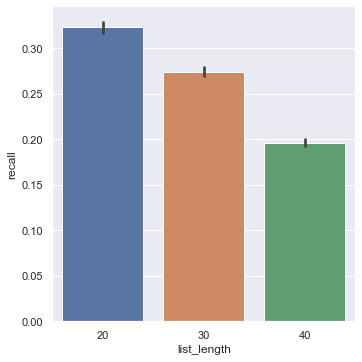

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

sns.lineplot(data=spc, x='input', y='recall', err_style='bars', hue='list_length', legend=True, ci=False)
plt.show()

max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='list_length', legend=False)
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='list_length', legend=True)
plt.show()

sns.lineplot(data=pfr, x='input', y='prob', err_style='bars', hue='list_length', legend=True)
plt.show()

sns.catplot(data=spc, x='list_length', y='recall', kind='bar')
plt.show()


In [ ]:
from compmemlearn.datasets import simulate_data
from psifr import fr

model0 = Classic_CMR(
    **{**{'item_count': murd_length2, 'presentation_count': murd_length2, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[0].x[i] for i in range(len(overall_cmr_results[0].x))}})

model1 = Classic_CMR(
    **{**{'item_count': murd_length2, 'presentation_count': murd_length2, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[1].x[i] for i in range(len(overall_cmr_results[1].x))}})

model2 = Classic_CMR(
    **{**{'item_count': murd_length2, 'presentation_count': murd_length2, 'sampling_rule': 0},
    **{free_parameters[i]:overall_cmr_results[2].x[i] for i in range(len(overall_cmr_results[2].x))}})

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)

dfs = [sim_df0, sim_df1, sim_df2]
labels = ['20', '30', '40']

spc = pd.concat([fr.spc(df) for df in dfs], keys=labels, names=['list_length']).reset_index()
lag_crp = pd.concat([fr.lag_crp(df) for df in dfs], keys=labels, names=['list_length']).reset_index()
pfr = pd.concat([fr.pnr(df) for df in dfs], keys=labels, names=['list_length']).reset_index()
pfr = pfr.query('output <= 1')

<AxesSubplot:xlabel='input', ylabel='recall'>

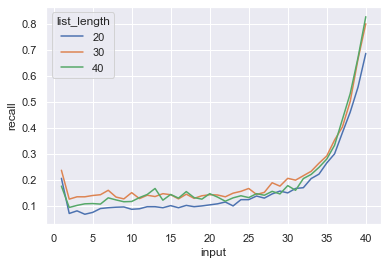

In [ ]:
import seaborn as sns

sns.set_theme(style="darkgrid")

sns.lineplot(data=spc, x='input', y='recall', err_style='bars', hue='list_length', legend=True, ci=False)

<AxesSubplot:xlabel='lag', ylabel='prob'>

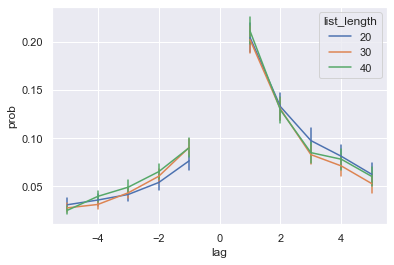

In [ ]:
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(data=lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='list_length', legend=False)
sns.lineplot(data=lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='list_length', legend=True)


<AxesSubplot:xlabel='input', ylabel='prob'>

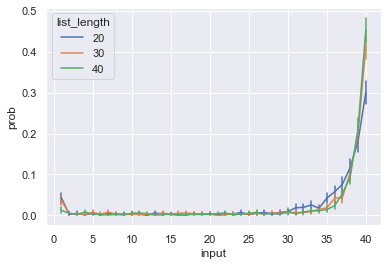

In [ ]:
sns.lineplot(data=pfr, x='input', y='prob', err_style='bars', hue='list_length', legend=True)

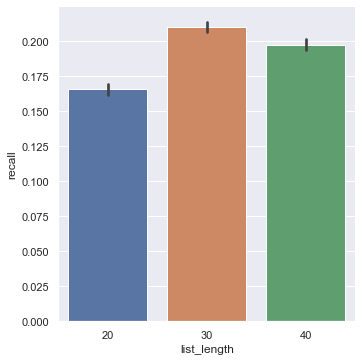

In [ ]:
sns.catplot(data=spc, x='list_length', y='recall', kind='bar')